In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pandas.plotting import parallel_coordinates

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV, 
    StratifiedKFold,
    ParameterGrid,
    train_test_split
)

try:
    import umap
except ImportError:
    !pip install umap-learn
    import umap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    classification_report,
)

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)



plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Librerías importadas correctamente")
print(f"Versión de scikit-learn: {__import__('sklearn').__version__}")

Librerías importadas correctamente
Versión de scikit-learn: 1.7.2


In [2]:
df = pd.read_csv('../data/processed/diabetes_sample.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,0.0,1.0,42.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0,4.0,2.0
1,0.0,0.0,0.0,1.0,19.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,30.0,0.0,0.0,0.0,7.0,5.0,8.0
2,0.0,0.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,6.0,8.0
3,0.0,0.0,0.0,1.0,31.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
4,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,6.0,8.0


In [3]:
target_col =  'Diabetes_012'
X = df.drop(columns=[target_col])
y = df[target_col]


print("Variables separadas:")
print(f"   X: {X.shape} → {X.shape[1]} features")
print(f"   y: {y.shape} → {y.nunique()} clases")
print(f"Features:")
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")

Variables separadas:
   X: (38052, 21) → 21 features
   y: (38052,) → 3 clases
Features:
    1. HighBP
    2. HighChol
    3. CholCheck
    4. BMI
    5. Smoker
    6. Stroke
    7. HeartDiseaseorAttack
    8. PhysActivity
    9. Fruits
   10. Veggies
   11. HvyAlcoholConsump
   12. AnyHealthcare
   13. NoDocbcCost
   14. GenHlth
   15. MentHlth
   16. PhysHlth
   17. DiffWalk
   18. Sex
   19. Age
   20. Education
   21. Income


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Datos divididos en entrenamiento y prueba:")
print(f"   X_train: {X_train.shape[0]} samples")   
print(f"   X_test : {X_test.shape[0]} samples")
print(f"   y_train: {y_train.shape[0]} samples")
print(f"   y_test : {y_test.shape[0]} samples")

Datos divididos en entrenamiento y prueba:
   X_train: 30441 samples
   X_test : 7611 samples
   y_train: 30441 samples
   y_test : 7611 samples


In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"Estrategia de validación cruzada: {cv}")

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    y_fold = y_train.iloc[val_idx]
    dist = y_fold.value_counts(normalize=True).sort_index()
    print(f"Fold {fold}: {len(val_idx):,} muestras → {dist.values}")

Estrategia de validación cruzada: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
Fold 1: 6,089 muestras → [0.84217441 0.01839382 0.13943176]
Fold 2: 6,088 muestras → [0.84231275 0.01823259 0.13945466]
Fold 3: 6,088 muestras → [0.842477   0.01823259 0.13929041]
Fold 4: 6,088 muestras → [0.842477   0.01823259 0.13929041]
Fold 5: 6,088 muestras → [0.842477   0.01823259 0.13929041]


In [6]:
base_model = LogisticRegression(random_state=42)

params = base_model.get_params()

print("Parámetros disponibles del modelo LogisticRegression:")
for param, valor in sorted(params.items()):
    print(f"{param:25s} = {valor}")

Parámetros disponibles del modelo LogisticRegression:
C                         = 1.0
class_weight              = None
dual                      = False
fit_intercept             = True
intercept_scaling         = 1
l1_ratio                  = None
max_iter                  = 100
multi_class               = deprecated
n_jobs                    = None
penalty                   = l2
random_state              = 42
solver                    = lbfgs
tol                       = 0.0001
verbose                   = 0
warm_start                = False


In [7]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],    
    'penalty': ['l2'],                       
    'solver': ['lbfgs', 'saga'],            
    'max_iter': [1000],                      
    'class_weight': ['balanced']            
}

print("\nHiperparámetros a explorar:")
for param, valores in param_grid_lr.items():
    print(f"\n{param}:")
    print(f"   Valores: {valores}")
    print(f"   N° opciones: {len(valores)}")


total_comb = len(list(ParameterGrid(param_grid_lr)))
print(f"\nTOTAL combinaciones: {total_comb}")
print(f"   Con 5-Fold CV: {total_comb * 5} entrenamientos")


Hiperparámetros a explorar:

C:
   Valores: [0.001, 0.01, 0.1, 1, 10, 100]
   N° opciones: 6

penalty:
   Valores: ['l2']
   N° opciones: 1

solver:
   Valores: ['lbfgs', 'saga']
   N° opciones: 2

max_iter:
   Valores: [1000]
   N° opciones: 1

class_weight:
   Valores: ['balanced']
   N° opciones: 1

TOTAL combinaciones: 12
   Con 5-Fold CV: 60 entrenamientos


In [8]:
grid = ParameterGrid(param_grid_lr)

print("\nListado de combinaciones a evaluar:")
for i, params in enumerate(grid, 1):
    print(f"{i:<4} {params['C']:<10.3f} {params['solver']:<12} "
          f"{params['penalty']:<10} {params['class_weight']:<15} {params['max_iter']:<10}")


Listado de combinaciones a evaluar:
1    0.001      lbfgs        l2         balanced        1000      
2    0.001      saga         l2         balanced        1000      
3    0.010      lbfgs        l2         balanced        1000      
4    0.010      saga         l2         balanced        1000      
5    0.100      lbfgs        l2         balanced        1000      
6    0.100      saga         l2         balanced        1000      
7    1.000      lbfgs        l2         balanced        1000      
8    1.000      saga         l2         balanced        1000      
9    10.000     lbfgs        l2         balanced        1000      
10   10.000     saga         l2         balanced        1000      
11   100.000    lbfgs        l2         balanced        1000      
12   100.000    saga         l2         balanced        1000      


In [9]:
# Configurar Grid Search
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid_lr,
    cv=cv,                              # Stratified K-Fold que se definio antes
    scoring='balanced_accuracy',        # Métrica principal (crítica para desbalance)
    n_jobs=-1,                          # Usar todos los cores del CPU
    verbose=2,                          # Nivel de detalle en la salida
    return_train_score=True             # Guardar scores de train para análisis
)

inicio = time.time()

# EJECUTAR LA BÚSQUEDA
grid_search_lr.fit(X_train, y_train)

tiempo_total = time.time() - inicio

print(f"Tiempo total: {tiempo_total/60:.2f} minutos ({tiempo_total:.1f} segundos)")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Tiempo total: 1.98 minutos (118.8 segundos)


In [10]:
mejores_params = grid_search_lr.best_params_
mejor_score = grid_search_lr.best_score_

print("\nMejores hiperparámetros encontrados:")
print("\nConfiguración óptima:")
for param, valor in mejores_params.items():
    print(f"{param:20s} = {valor}")

print(f"\nMejor Balanced Accuracy (CV): {mejor_score:.4f}")

mejor_modelo_lr = grid_search_lr.best_estimator_
print(f"\nEl modelo óptimo ya está entrenado y listo para usar")
print(f"Variable: {mejor_modelo_lr}")


Mejores hiperparámetros encontrados:

Configuración óptima:
C                    = 0.01
class_weight         = balanced
max_iter             = 1000
penalty              = l2
solver               = lbfgs

Mejor Balanced Accuracy (CV): 0.5232

El modelo óptimo ya está entrenado y listo para usar
Variable: LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000,
                   random_state=42)


In [11]:
results = pd.DataFrame(grid_search_lr.cv_results_)

columns_target = [
    'param_C',
    'param_solver',
    'mean_train_score',
    'std_train_score',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

results_subset = results[columns_target].copy()
results_subset = results[columns_target].sort_values(by='rank_test_score')

print("\nResultados resumidos de la búsqueda ordenados por score:")

print(results_subset.to_string(index=False))


Resultados resumidos de la búsqueda ordenados por score:
 param_C param_solver  mean_train_score  std_train_score  mean_test_score  std_test_score  rank_test_score
   0.010        lbfgs          0.530847         0.005244         0.523217        0.017371                1
   0.100        lbfgs          0.531907         0.005412         0.520625        0.016890                2
   1.000        lbfgs          0.532044         0.005190         0.520390        0.017072                3
 100.000        lbfgs          0.532094         0.005239         0.520351        0.017032                4
  10.000        lbfgs          0.532123         0.005202         0.520245        0.017070                5
   0.010         saga          0.527798         0.008217         0.519624        0.012929                6
   0.001        lbfgs          0.526490         0.002444         0.515252        0.017090                7
 100.000         saga          0.526212         0.006515         0.514502        0.007

In [12]:
mejor_c = mejores_params['C']
mejor_solver = mejores_params['solver']
mejor_ba = mejor_score

mejor_idx = grid_search_lr.best_index_
train_score = results.loc[mejor_idx, 'mean_train_score']
test_score = mejor_ba
gap = train_score - test_score


print(f"\nAnálisis de Overfitting:")
print(f"Train BA: {train_score:.4f}")
print(f"Test BA:  {test_score:.4f}")
print(f"Gap:      {gap:.4f}")

if gap < 0.02:
    print(f"Gap pequeño → Buen balance sesgo-varianza")
elif gap < 0.05:
    print(f"Gap moderado → Ligero overfitting")
else:
    print(f"Gap grande → Posible overfitting")


print(f"\nDesempeño por solvers para C = {mejor_c}:")
best_c = results[results['param_C'] == mejor_c]
for _, row in best_c.iterrows():
    solver = row['param_solver']
    ba = row['mean_test_score']
    print(f"{solver:10s}: BA = {ba:.4f}")


Análisis de Overfitting:
Train BA: 0.5308
Test BA:  0.5232
Gap:      0.0076
Gap pequeño → Buen balance sesgo-varianza

Desempeño por solvers para C = 0.01:
lbfgs     : BA = 0.5232
saga      : BA = 0.5196


In [13]:
y_pred_test = mejor_modelo_lr.predict(X_test)
y_pred_proba = mejor_modelo_lr.predict_proba(X_test)

ba_test = balanced_accuracy_score(y_test, y_pred_test)
f1_macro = f1_score(y_test, y_pred_test, average='macro')
f1_weighted = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nMÉTRICAS EN TEST SET:")
print(f"Balanced Accuracy: {ba_test:.4f}")
print(f"F1-Score (Macro):  {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

print(f"\nComparación CV vs Test:")
print(f"CV (validación cruzada): {mejor_score:.4f}")
print(f"Test (datos no vistos):  {ba_test:.4f}")
print(f"Diferencia: {abs(mejor_score - ba_test):.4f}")


MÉTRICAS EN TEST SET:
Balanced Accuracy: 0.4943
F1-Score (Macro):  0.4191
F1-Score (Weighted): 0.7170

Comparación CV vs Test:
CV (validación cruzada): 0.5232
Test (datos no vistos):  0.4943
Diferencia: 0.0289


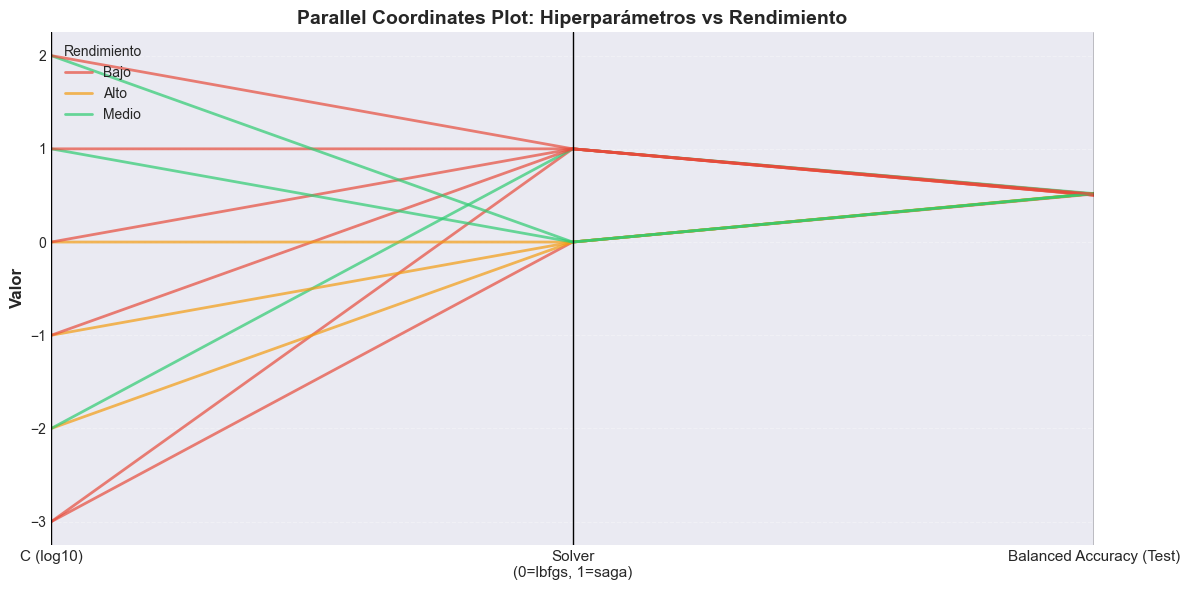

In [14]:
resultados_plot = pd.DataFrame({
    'C': results['param_C'],
    'solver': results['param_solver'],
    'Test_Score': results['mean_test_score'],
    'Train_Score': results['mean_train_score']
})

# Convertir solver a numérico para el plot
resultados_plot['solver_num'] = resultados_plot['solver'].map({
    'lbfgs': 0,
    'saga': 1
})

# Crear categorías de rendimiento
percentil_75 = resultados_plot['Test_Score'].quantile(0.75)
percentil_50 = resultados_plot['Test_Score'].quantile(0.50)

def categorizar_rendimiento(score):
    if score >= percentil_75:
        return 'Alto'
    elif score >= percentil_50:
        return 'Medio'
    else:
        return 'Bajo'

resultados_plot['Rendimiento'] = resultados_plot['Test_Score'].apply(categorizar_rendimiento)

# 2. Crear el plot
fig, ax = plt.subplots(figsize=(12, 6))

# Seleccionar columnas para el parallel plot
columnas_plot = ['C', 'solver_num', 'Test_Score']
df_parallel = resultados_plot[columnas_plot + ['Rendimiento']].copy()

# Normalizar C a escala logarítmica para mejor visualización
df_parallel['C_log'] = np.log10(df_parallel['C'])
df_parallel = df_parallel.drop('C', axis=1)

# Reordenar columnas
df_parallel = df_parallel[['C_log', 'solver_num', 'Test_Score', 'Rendimiento']]

# Crear el plot
parallel_coordinates(
    df_parallel, 
    'Rendimiento',
    color=['#e74c3c', '#f39c12', '#2ecc71'],  # Rojo, Naranja, Verde
    alpha=0.7,
    linewidth=2
)

# Personalizar ejes
ax.set_xticks(range(len(['C (log10)', 'Solver', 'Test Score'])))
ax.set_xticklabels(['C (log10)', 'Solver\n(0=lbfgs, 1=saga)', 'Balanced Accuracy (Test)'], 
                   fontsize=11)
ax.set_ylabel('Valor', fontsize=12, fontweight='bold')
ax.set_title('Parallel Coordinates Plot: Hiperparámetros vs Rendimiento', 
             fontsize=14, fontweight='bold')

# Ajustar leyenda
ax.legend(title='Rendimiento', loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

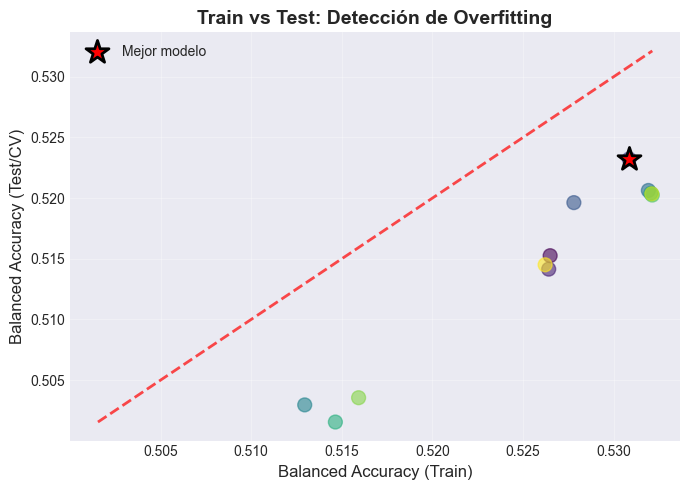

In [15]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(
    results['mean_train_score'],
    results['mean_test_score'],
    s=100,
    alpha=0.6,
    c=range(len(results)),
    cmap='viridis'
)

min_val = min(results['mean_train_score'].min(), results['mean_test_score'].min())
max_val = max(results['mean_train_score'].max(), results['mean_test_score'].max())

ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='red',
    linestyle='--',
    linewidth=2,
    alpha=0.7
)

best_training = results.loc[mejor_idx, 'mean_train_score']
best_test = mejor_score

ax.scatter(
    best_training,
    best_test,
    s=300,
    c='red',
    marker='*',
    edgecolors='black',
    linewidth=2,
    label='Mejor modelo',
    zorder=5
)

# Etiquetas y título
ax.set_xlabel('Balanced Accuracy (Train)', fontsize=12)
ax.set_ylabel('Balanced Accuracy (Test/CV)', fontsize=12)
ax.set_title('Train vs Test: Detección de Overfitting', fontsize=14, fontweight='bold')

ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
target_names = ['No Diabetes', 'Pre-diabetes', 'Diabetes']
print(classification_report(y_test, y_pred_test, target_names=target_names, digits=4))

              precision    recall  f1-score   support

 No Diabetes     0.9488    0.6594    0.7781      6412
Pre-diabetes     0.0241    0.2302    0.0437       139
    Diabetes     0.3441    0.5934    0.4356      1060

    accuracy                         0.6424      7611
   macro avg     0.4390    0.4943    0.4191      7611
weighted avg     0.8477    0.6424    0.7170      7611



In [17]:
y_pred_train = mejor_modelo_lr.predict(X_train)
ba_train = balanced_accuracy_score(y_train, y_pred_train)

print(f"\nTrain:           BA = {ba_train:.4f}")
print(f"Validation (CV): BA = {mejor_score:.4f}")
print(f"Test:            BA = {ba_test:.4f}")


Train:           BA = 0.5274
Validation (CV): BA = 0.5232
Test:            BA = 0.4943


In [18]:
print("EJEMPLO DE PREDICCIÓN CON PACIENTES REALES")

n_ejemplos = 5
indices_aleatorios = np.random.choice(len(X_test), size=n_ejemplos, replace=False)

pacientes_ejemplo = X_test.iloc[indices_aleatorios]
realidad = y_test.iloc[indices_aleatorios]

print(f"\nAnalizando {n_ejemplos} pacientes del test set...\n")

# 2. Hacer predicciones
predicciones = mejor_modelo_lr.predict(pacientes_ejemplo)
probabilidades = mejor_modelo_lr.predict_proba(pacientes_ejemplo)

# 3. Mapeo de clases
clase_nombres = {0: 'No Diabetes', 1: 'Pre-diabetes', 2: 'Diabetes'}

# 4. Mostrar resultados paciente por paciente
for i, idx in enumerate(indices_aleatorios):
    print("="*70)
    print(f"PACIENTE #{idx}")
    print("="*70)
    
    # Características del paciente
    print("\nCaracterísticas del paciente:")
    print("-"*70)
    for col in X_test.columns[:10]:  # Mostrar primeras 10 features
        valor = pacientes_ejemplo.iloc[i][col]
        print(f"   {col:25s}: {valor}")
    print(f"   ... (y {len(X_test.columns)-10} características más)")
    
    # Diagnóstico real
    clase_real = int(realidad.iloc[i])
    print(f"\nDIAGNÓSTICO REAL:")
    print(f"   {clase_nombres[clase_real]}")
    
    # Predicción del modelo
    clase_pred = int(predicciones[i])
    print(f"\nPREDICCIÓN DEL MODELO:")
    print(f"   {clase_nombres[clase_pred]}")
    
    # Probabilidades
    probs = probabilidades[i]
    print(f"\nCONFIANZA DE LA PREDICCIÓN:")
    print("-"*70)
    for clase_num, prob in enumerate(probs):
        print(f"{clase_nombres[clase_num]:15s}: {prob:6.2%}")
    
    # Resultado
    if clase_pred == clase_real:
        print(f"\nPREDICCIÓN CORRECTA")
    else:
        print(f"\nPREDICCIÓN INCORRECTA")
        print(f"   El modelo predijo '{clase_nombres[clase_pred]}'")
        print(f"   pero el diagnóstico real era '{clase_nombres[clase_real]}'")
    
    print()

print("RESUMEN DE LOS EJEMPLOS")

correctas = np.sum(predicciones == realidad.values)
print(f"\nPredicciones correctas: {correctas}/{n_ejemplos} ({correctas/n_ejemplos:.1%})")
print(f"Predicciones incorrectas: {n_ejemplos-correctas}/{n_ejemplos} ({(n_ejemplos-correctas)/n_ejemplos:.1%})")

EJEMPLO DE PREDICCIÓN CON PACIENTES REALES

Analizando 5 pacientes del test set...

PACIENTE #2644

Características del paciente:
----------------------------------------------------------------------
   HighBP                   : 0.0
   HighChol                 : 0.0
   CholCheck                : 1.0
   BMI                      : 36.0
   Smoker                   : 0.0
   Stroke                   : 0.0
   HeartDiseaseorAttack     : 0.0
   PhysActivity             : 0.0
   Fruits                   : 0.0
   Veggies                  : 1.0
   ... (y 11 características más)

DIAGNÓSTICO REAL:
   No Diabetes

PREDICCIÓN DEL MODELO:
   Pre-diabetes

CONFIANZA DE LA PREDICCIÓN:
----------------------------------------------------------------------
No Diabetes    : 33.51%
Pre-diabetes   : 37.65%
Diabetes       : 28.83%

PREDICCIÓN INCORRECTA
   El modelo predijo 'Pre-diabetes'
   pero el diagnóstico real era 'No Diabetes'

PACIENTE #2227

Características del paciente:
--------------------------

In [19]:
resultados =  pd.DataFrame({
    'Modelo': 'Logistic regression',
    'BA Train': ba_train,
    'BA CV': mejor_score,
    'BA Test': ba_test
}, index=[0])

print(resultados)

resultados.to_csv("../data/data_models/logistic_regression.csv", index=False)
print("Resultados guardados en '.../data/data_models'")

                Modelo  BA Train     BA CV   BA Test
0  Logistic regression  0.527378  0.523217  0.494334
Resultados guardados en '.../data/data_models'


# Reducción de dimensión 

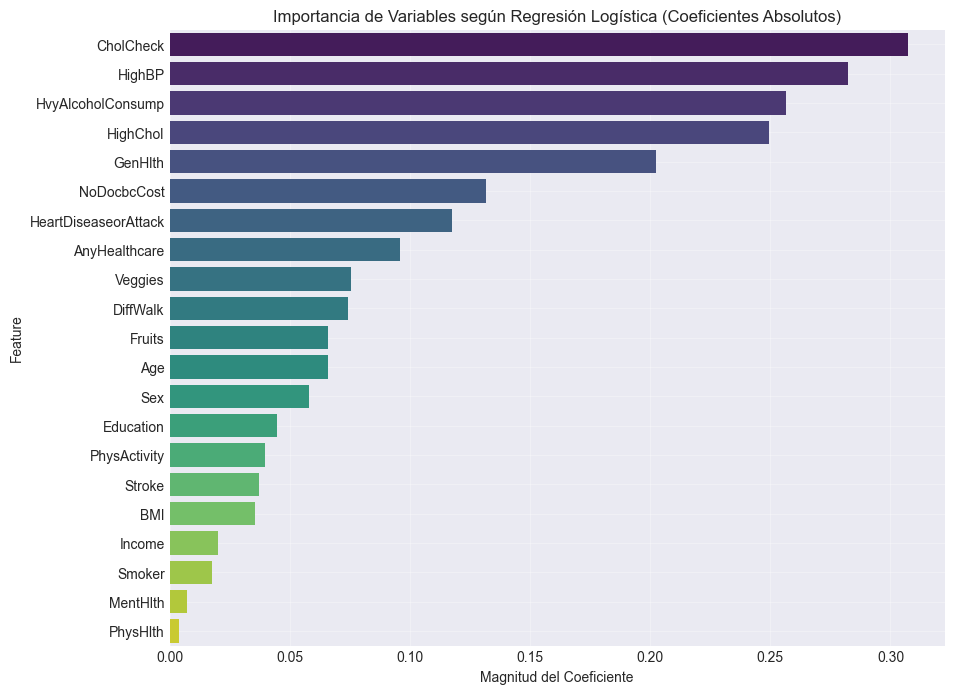

Variables con menor impacto en LR:
     Feature  Importance
3        BMI    0.035375
20    Income    0.020118
4     Smoker    0.017689
14  MentHlth    0.007339
15  PhysHlth    0.004137


In [20]:
# 1. Extraer la importancia (promedio absoluto de los coeficientes para las 3 clases)
# coef_ tiene forma (n_clases, n_features), promediamos para tener un valor global por variable
importancia_lr = np.mean(np.abs(mejor_modelo_lr.coef_), axis=0)
feature_names = X_train.columns

# 2. Crear DataFrame
df_imp_lr = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importancia_lr
}).sort_values(by='Importance', ascending=False)

# 3. Visualizar
plt.figure(figsize=(10, 8))
sns.barplot(data=df_imp_lr, x='Importance', y='Feature', palette='viridis')
plt.title('Importancia de Variables según Regresión Logística (Coeficientes Absolutos)')
plt.xlabel('Magnitud del Coeficiente')
plt.grid(True, alpha=0.3)
plt.show()

# 4. Ver candidatas a eliminar (ej. peso menor a 0.05)
print("Variables con menor impacto en LR:")
print(df_imp_lr.tail(5))

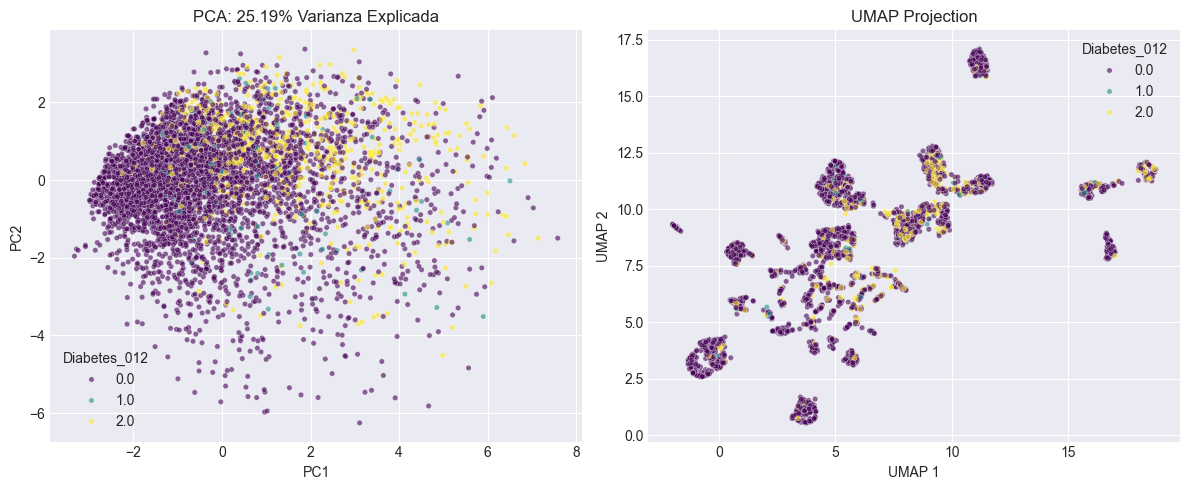

In [25]:
# --- PREPARACIÓN ---
# Usamos una muestra para agilizar la visualización (opcional, si tienes muchos datos)
indices = np.random.choice(len(X_train), size=min(5000, len(X_train)), replace=False)
X_sample = X_train.iloc[indices]
y_sample = y_train.iloc[indices]

# Escalar (Obligatorio para PCA/UMAP)
scaler_viz = StandardScaler()
X_sample_scaled = scaler_viz.fit_transform(X_sample)

# --- A. PCA (Lineal) ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(12, 5))

# Plot PCA
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_sample, palette='viridis', alpha=0.6, s=15)
plt.title(f'PCA: {np.sum(pca.explained_variance_ratio_):.2%} Varianza Explicada')
plt.xlabel('PC1')
plt.ylabel('PC2')

# --- B. UMAP (No Lineal) ---
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_sample_scaled)

# Plot UMAP
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_sample, palette='viridis', alpha=0.6, s=15)
plt.title('UMAP Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()

In [27]:
# 1. Preparación de Datos (Escalado es OBLIGATORIO para PCA/UMAP)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
n_features_orig = X_train.shape[1]


pca_full = PCA()
pca_full.fit(X_train_sc)

# b. Buscar el n_components para 95% de varianza
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum >= 0.95) + 1 # +1 porque el índice empieza en 0

# c. Transformar los datos con el N óptimo
pca_opt = PCA(n_components=n_components_95)
X_train_pca = pca_opt.fit_transform(X_train_sc)
X_test_pca = pca_opt.transform(X_test_sc)

# d. Re-entrenar Regresión Logística con datos PCA
# Usamos los mismos hiperparámetros del mejor modelo encontrado anteriormente
lr_pca = LogisticRegression(C=mejor_modelo_lr.C, solver=mejor_modelo_lr.solver, 
                            class_weight='balanced', max_iter=1000, random_state=42)
lr_pca.fit(X_train_pca, y_train)

# e. Evaluar
ba_pca = balanced_accuracy_score(y_test, lr_pca.predict(X_test_pca))

# a. Ajustar y Transformar UMAP
# n_neighbors=15 es estándar. min_dist=0.1 compacta los clusters.
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_train_umap = umap_model.fit_transform(X_train_sc)
X_test_umap = umap_model.transform(X_test_sc) # Transformar test con el mapeo aprendido

# b. Re-entrenar Regresión Logística con datos UMAP
lr_umap = LogisticRegression(C=mejor_modelo_lr.C, solver=mejor_modelo_lr.solver, 
                             class_weight='balanced', max_iter=1000, random_state=42)
lr_umap.fit(X_train_umap, y_train)

# c. Evaluar
ba_umap = balanced_accuracy_score(y_test, lr_umap.predict(X_test_umap))


# Calcular BA original (Referencia)
ba_orig = balanced_accuracy_score(y_test, mejor_modelo_lr.predict(X_test))

# Calcular porcentajes de reducción
red_pca = (1 - n_components_95 / n_features_orig) * 100
red_umap = (1 - 2 / n_features_orig) * 100

results_data = {
    'Método': ['Original (Todas las Features)', f'PCA ({n_components_95} Comp. - 95% Var)', 'UMAP (2 Comp. - No Lineal)'],
    'N_Features': [n_features_orig, n_components_95, 2],
    '% Reducción Dim.': [0.0, red_pca, red_umap],
    'Balanced Accuracy (Test)': [ba_orig, ba_pca, ba_umap]
}

df_results_lr = pd.DataFrame(results_data)
display(df_results_lr) # Si no estás en Jupyter usa print(df_results_lr)

,Método,N_Features,% Reducción Dim.,Balanced Accuracy (Test)
0,Original (Todas las Features),21,0.00000,0.494334
1,PCA (19 Comp. - 95% Var),19,9.52381,0.502269
2,UMAP (2 Comp. - No Lineal),2,90.47619,0.380695
